In [8]:
import os
import pandas as pd
import numpy as np

In [9]:
os.getcwd()

'C:\\Users\\User\\Desktop\\Power Management GPU\\power_modeling\\accel-sim-framework'

In [36]:

target_dir = '100iter_sample_per_500cycle'
cycles_between_samples = 500

target_dir = '10iter_processed'
cycles_between_samples = 1

target_path = os.path.join('logs_accelwattch',target_dir)
energy_dict = {}
plotting_dict = {}
# Define the processor frequency (in MHz)
processor_frequency_MHz = 1312
cycles_per_second = processor_frequency_MHz * 10**6
# Calculate the duration of one cycle (in seconds)
cycle_duration = 1 / cycles_per_second
sample_duration = cycle_duration * cycles_between_samples

static_power=32.32522272

for file in os.listdir(target_path):
    file_path = os.path.join(target_path,file)
#     print(file)
    benchmark = file.split('.accelsim')[0].replace(f'-{target_dir.split("iter")[0]}','')
    if file.endswith('csv') and benchmark not in energy_dict and benchmark not in plotting_dict:
        df = pd.read_csv(file_path)
        dyn_energy = np.trapz(df['runtime_dynamic_W'], dx=sample_duration)
        static_power_resized = np.resize(static_power, len(df))
        static_energy = np.trapz(static_power_resized, dx=sample_duration)
        total_energy = dyn_energy + static_energy
        energy_dict[benchmark]=(total_energy,dyn_energy,static_energy,len(df)*cycles_between_samples)
        plotting_dict[benchmark]=df['runtime_dynamic_W']


In [37]:
# Unpack the tuples into separate lists
data = [(benchmark, *values) for benchmark, values in energy_dict.items()]

# Create a DataFrame
energy_df = pd.DataFrame(data, columns=['benchmark', 'total_energy_J', 'dyn_energy_J', 'static_energy_J', 'cycles'])
energy_df.to_csv(f'{target_dir}_energy.csv',index=False)
energy_df

,benchmark,total_energy_J,dyn_energy_J,static_energy_J,cycles
0,ACT_CORE2_16_32,0.000466,0.000216,0.000250,10128
1,ACT_CORE2_1_32,0.000427,0.000180,0.000247,10040
2,ACT_CORE2_32_32,0.000508,0.000256,0.000253,10254
3,ACT_CORE2_48_32,0.000554,0.000295,0.000259,10520
4,ACT_CORE2_64_32,0.000604,0.000335,0.000269,10922
...,...,...,...,...,...
90,mix9,0.000404,0.000213,0.000192,7784
91,mul_add_tex_1,0.002441,0.001691,0.000750,30454
92,REG_FILE,0.001012,0.000712,0.000300,12173
93,SHRD_TEX_SFU,0.002248,0.001529,0.000719,29189


In [43]:
target_dirs = ['100iter_sample_per_500cycle','10iter_processed']
total_df = None
for target_dir in target_dirs:
    target_file = f'{target_dir}_energy.csv'
    if total_df is None:
        total_df = pd.read_csv(target_file)
    else:
        new_df = pd.read_csv(target_file)
        total_df = total_df.merge(new_df, on="benchmark", suffixes=('', target_dir.split("iter")[0]))
total_df.to_csv(f'accelwattch_energy.csv',index=False)

In [46]:
target_benchmark = 'TENSOR'
df = benchmark_dict[target_benchmark]
df


KeyError: 'TENSOR'

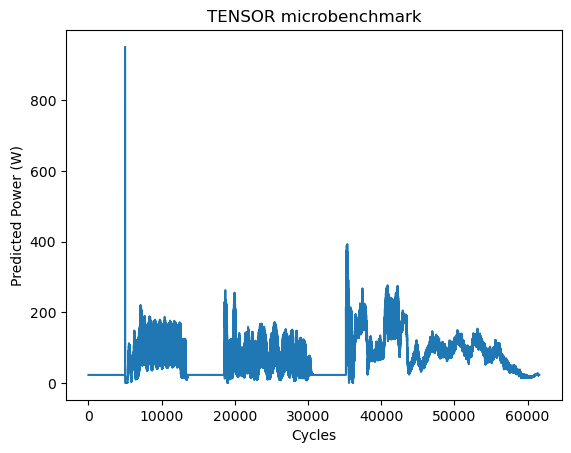

951.254

In [54]:
#Let's just plot some stuff
import matplotlib.pyplot as plt

target_benchmark = 'TENSOR'
data = plotting_dict[target_benchmark]

plt.plot(data)
plt.title(f'{target_benchmark} microbenchmark')
plt.xlabel('Cycles')
plt.ylabel('Predicted Power (W)')
plt.show()
max(data)